In [1]:
from pocovidnet.evaluate_covid19 import Evaluator
import os
import numpy as np
import cv2
from imutils import paths
from sklearn.metrics import (
    classification_report, confusion_matrix, balanced_accuracy_score,
    accuracy_score, matthews_corrcoef
)
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
import pickle
import pandas as pd

from plots import *

In [2]:
CLASS_MAPPING = {
    3: ['covid', 'pneumonia', 'regular']
}

In [3]:
args_model_val = {
    'data': './image_cross_val',
    'weights': './trained_models/model_16/val',
    'm_id': 'vgg_16',
    'classes': 3,
    'folds': 5,
    'save_path': 'results_vgg',
}

In [4]:
def mcc_multiclass(y_true, y_pred):
    """
    MCC score for multiclass problem
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mcc_out = []
    for classe in np.unique(y_true):
        y_true_binary = (y_true == classe).astype(int)
        y_pred_binary = (y_pred == classe).astype(int)
        mcc_out.append(matthews_corrcoef(y_true_binary, y_pred_binary))
    return mcc_out

In [5]:
def specificity(y_true, y_pred):
    """
    Compute specificity for multiclass predictions
    """
    # true negatives / negatives
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    spec_out = []
    for classe in np.unique(y_true):
        negatives = np.sum((y_true != classe).astype(int))
        tn = np.sum((y_pred[y_true != classe] != classe).astype(int))
        spec_out.append(tn / negatives)
    return spec_out

In [6]:
def load_encoding(imagePath, FEAT_ID=0, w=7, h=9, pool=True):
    data = np.load(imagePath)

    if FEAT_ID > 0 and FEAT_ID < 4:
        feats = [FEAT_ID]
    elif type(FEAT_ID) != int:
        raise TypeError('Give int as feature type')
    else:
        feats = [1, 2, 3]

    sample = []
    for feat in feats:
        # Use individual features
        image = cv2.resize(data['f' + str(feat)][0, :, :, :], (w, h))
        sp = np.mean(image, axis=(0, 1)) if pool else image.flatten()
        sample.append(sp)
    sample = np.concatenate(sample).flatten()
    return sample

In [7]:
def evaluate_logits(saved_logits, saved_gt, saved_files, CLASSES, save_path):
    all_reports, accs, bal_accs = [], [], []
    for s in range(5):
        gt_s = saved_gt[s]
        pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1) # p.e [-3.851456  , -0.02610361, -5.3998914 ]: -0.02610361
        report = classification_report(
            gt_s, pred_idx_s, target_names=CLASSES, output_dict=True
        )
        mcc_scores = mcc_multiclass(gt_s, pred_idx_s)
        spec_scores = specificity(gt_s, pred_idx_s)
        for i, cl in enumerate(CLASSES):
            report[cl]["mcc"] = mcc_scores[i]
            report[cl]["specificity"] = spec_scores[i]
        df = pd.DataFrame(report).transpose()
        df = df.drop(columns="support")
        df["accuracy"] = [report["accuracy"] for _ in range(len(df))]
        bal = balanced_accuracy_score(gt_s, pred_idx_s)
        df["balanced"] = [bal for _ in range(len(df))]
        accs.append(report["accuracy"])
        bal_accs.append(balanced_accuracy_score(gt_s, pred_idx_s))
        all_reports.append(np.array(df)[:len(CLASSES)])
        
    print("Average scores in cross validation:")
    df_arr = np.around(np.mean(all_reports, axis=0), 3)
    df_classes = pd.DataFrame(
        df_arr,
        columns=[
            "Precision", "Recall", "F1-score", "MCC", "Specificity",
            "Accuracy", "Balanced"
        ],
        index=CLASSES
    )
    print(df_classes)
    df_classes.to_csv(save_path + "_mean.csv")

    print("Standard deviations:")
    df_std = np.around(np.std(all_reports, axis=0), 2)
    df_std = pd.DataFrame(
        df_std,
        columns=[
            "Precision", "Recall", "F1-score", "MCC", "Specificity",
            "Accuracy", "Balanced"
        ],
        index=CLASSES
    )
    df_std.to_csv(save_path + "_std.csv")
    print(df_std)

In [8]:
def evaluate_3(saved_logits, saved_gt, saved_files, CLASSES, save_path):
    new_logits, new_gt, new_files = [], [], []
    counter = 0
    for i in range(5):
        gt_inds = np.where(np.array(saved_gt[i]) < 3)[0]
        counter += len(gt_inds)
        new_logits.append(np.array(saved_logits[i])[gt_inds, :3])
        new_gt.append(np.array(saved_gt[i])[gt_inds])
        new_files.append(np.array(saved_files[i])[gt_inds])

    with open(save_path + "_3.dat", "wb") as outfile:
        pickle.dump((new_logits, new_gt, new_files), outfile)
    evaluate_logits(new_logits, new_gt, new_files, CLASSES, save_path + "_3")

In [9]:
saved_logits, saved_gt, saved_files = [], [], []

CLASSES = CLASS_MAPPING[args_model_val['classes']]
MOD_FILE_MAP = {
    'vgg_16': ['gif', 'jpg', 'png', 'peg'],
    'vgg_cam': ['jpg', 'png', 'peg']
}

In [11]:
os.path.join(args_model_val['data'], "split" + str(1))

'./image_cross_val/split1'

In [12]:
args_model_val['weights']

'./trained_models/model_16/val'

In [13]:
for i in range(args_model_val['folds']):
        print("------------- SPLIT ", i, "-------------------")
        # define data input path
        path = os.path.join(args_model_val['data'], "split" + str(i))

        test_labels, test_files = [], []
        test_data = []
        
        # loop over the image paths (train and test)
        for imagePath in paths.list_files(path):
            # ejemplo:
            # ./image_cross_val/split0/pneumonia/Pneu-grep-bacterial-hepatization-clinical.mp4_frame192.jpg
            # select the correct files/ Busca una extensión definida en MOD_FILE_MAP
            # Si la extensión de la imagen (.jpg) no está en MOD_...
            if imagePath[-3:] not in MOD_FILE_MAP[args_model_val['m_id']]:
                continue

            # extract the class label from the filename
            label_class = imagePath.split(os.path.sep)[-2] # covid, neumonía, regular

            # load the image
            if args_model_val['m_id'] == 'dense':
                image = load_encoding(imagePath)
            elif imagePath[-3:] == 'gif':
                cap = cv2.VideoCapture(imagePath)
                ret, image = cap.read()
            else:
                image = cv2.imread(imagePath)
            
            # update the data and labels lists, respectively
            test_labels.append(label_class)
            test_data.append(image)
            test_files.append(imagePath.split(os.path.sep)[-1]) # nombre de la imágen con su extensión (Pneu_liftl_pneu_case3_clip4.mp4_frame30.jpg)
            
        if args_model_val['m_id'] == 'dense':
            test_data = np.expand_dims(np.stack(test_data), 1)
            preprocess = False
        else:
            preprocess = True
                
        # build ground truth data
        gt_class_idx = np.array([CLASSES.index(lab) for lab in test_labels])
        model = None
        # load model
        model = Evaluator(
            weights_dir=args_model_val['weights'],
            ensemble=False,
            split=i,
            num_classes=len(CLASSES),
            model_id=args_model_val['m_id']
        )
        print("testing on n_files:", len(test_data))
        
        # MAIN STEP: feed through model and compute logits
        logits = np.array(
            [model(img, preprocess=preprocess) for img in test_data]
        )

        # remember for evaluation:
        saved_logits.append(logits)
        saved_gt.append(gt_class_idx)
        saved_files.append(test_files)

        # output the information
        predIdxs = np.argmax(logits, axis=1)

        print(
            classification_report(
                gt_class_idx, predIdxs, target_names=CLASSES
            )
        )

------------- SPLIT  0 -------------------
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
testing on n_files: 269
              precision    recall  f1-score   support

       covid       0.82      0.83      0.82       104
   pneumonia       1.00      0.99      0.99        93
     regular       0.75      0.75      0.75        72

    accuracy                           0.86       269
   macro avg       0.86      0.86      0.86       269
weighted avg       0.86      0.86      0.86       269

------------- SPLIT  1 -------------------
Model restored. Class mappings are ['covid', 'pneumonia', 'regular']
testing on n_files: 350
              precision    recall  f1-score   support

       covid       0.84      0.91      0.87       165
   pneumonia       0.99      0.94      0.97       121
     regular       0.72      0.64      0.68        64

    accuracy                           0.87       350
   macro avg       0.85      0.83      0.84       350
weighted avg       0.

In [14]:
 with open(args_model_val['save_path'] + ".dat", "wb") as outfile:
        pickle.dump((saved_logits, saved_gt, saved_files), outfile)

In [26]:
# EVALUATE
evaluate_logits(
    saved_logits, saved_gt, saved_files, CLASSES, args_model_val['save_path']
)

Average scores in cross validation:
           Precision  Recall  F1-score    MCC  Specificity  Accuracy  Balanced
covid          0.873   0.912     0.892  0.788        0.872     0.887     0.869
pneumonia      0.928   0.925     0.924  0.906        0.982     0.887     0.869
regular        0.845   0.770     0.805  0.747        0.953     0.887     0.869
Standard deviations:
           Precision  Recall  F1-score   MCC  Specificity  Accuracy  Balanced
covid           0.04    0.06      0.05  0.08         0.02      0.04      0.03
pneumonia       0.08    0.08      0.07  0.08         0.02      0.04      0.03
regular         0.11    0.09      0.10  0.13         0.04      0.04      0.03


In [27]:
# EVALUATE ONLY 3 CLASSES
if len(CLASSES) == 4:
    evaluate_3(
        saved_logits, saved_gt, saved_files, CLASS_MAPPING[3],
        args.save_path
    )

### Evaluar Modelo

In [28]:
with open("results_vgg.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)

#### Sum up confusion matrices

In [29]:
all_cms = np.zeros((5,3,3))
for s in range(5):
    # print(saved_files[s])
    gt_s = saved_gt[s]
    pred_idx_s = np.argmax(np.array(saved_logits[s]), axis=1)
    assert len(gt_s)==len(pred_idx_s)
    cm = np.array(confusion_matrix(gt_s, pred_idx_s))
    all_cms[s] = cm

## Confusion Matrix

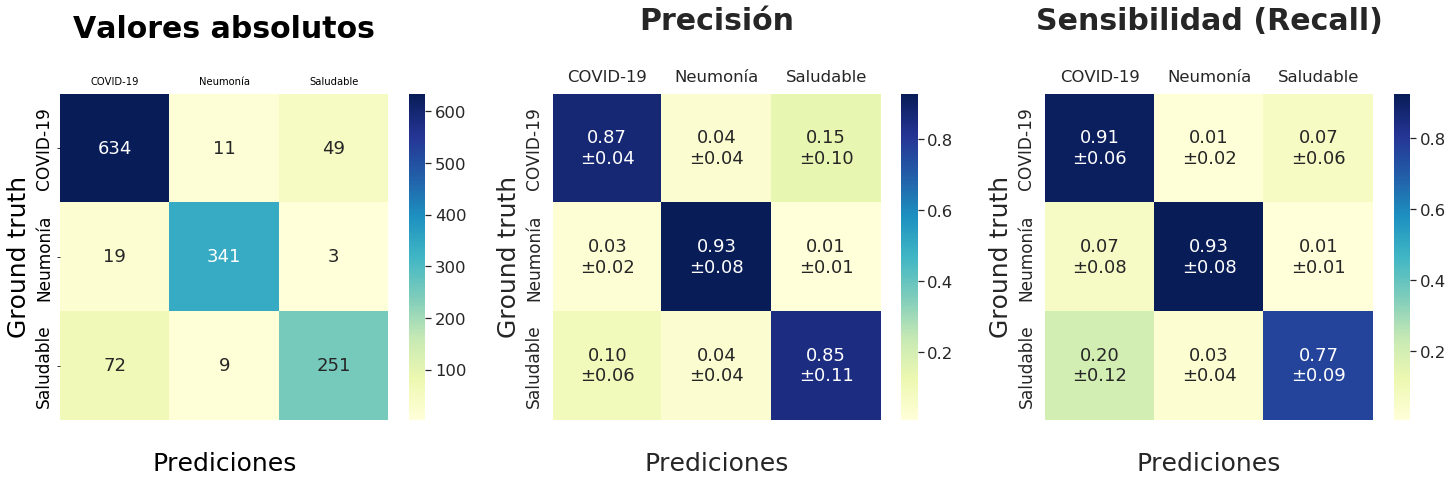

In [30]:
Plots.confusion_matrix_plot(all_cms)

## ROC AUC

In [31]:
from matplotlib import rc
plt.rcParams['legend.title_fontsize'] = 20

# plt.rcParams['axes.facecolor'] = 'white'
# activate latex text rendering
rc('text', usetex=False)

### Load data

In [32]:
with open("results_vgg.dat", "rb") as outfile:
    (saved_logits, saved_gt, saved_files) = pickle.load(outfile)
data, max_points, scores, roc_auc_std = Plots.roc_auc(saved_logits, saved_gt)

In [33]:
cols = ["red", "orange", "green"]
classes = ["COVID-19", "Pneumonia", "Healthy"]
classes_sp =["COVID-19", "Neumonía", "Saludable"]

#### ROC class comparison

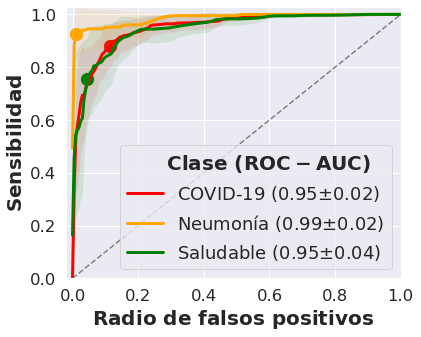

In [34]:
Plots.roc_sensibility_comparison(cols, classes_sp, data, max_points, scores, roc_auc_std)